# Analysis of Generated Sequences

In [6]:
# !pip install levenshtein

In [7]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Levenshtein import distance as levenshtein_distance

In [8]:
def read_fasta(filepath):
    """Read sequences from a FASTA file."""
    sequences = []
    with open(filepath, 'r') as f:
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if seq:
                    sequences.append(seq)
                    seq = ""
            else:
                seq += line
        if seq:
            sequences.append(seq)
    return sequences

def calculate_similarity(seq1, seq2):
    """
    Calculate sequence similarity as 1 - (normalized edit distance).
    Returns a value between 0 (completely different) and 1 (identical).
    """
    max_len = max(len(seq1), len(seq2))
    if max_len == 0:
        return 1.0
    edit_dist = levenshtein_distance(seq1, seq2)
    similarity = 1 - (edit_dist / max_len)
    return similarity

## Temp = 1

In [9]:
# dir with generated seqs
aptamers = ["2AU4", "5KPY", "6E8T", "8HZL"]
base_dir = "./generated_seqs/"
fasta_dir = "./aptamers/fasta/"

In [10]:
results = []

# Process each aptamer
for aptamer in aptamers:
    # Read reference sequence
    ref_file = os.path.join(fasta_dir, f"{aptamer}.fasta")
    ref_seqs = read_fasta(ref_file)
    ref_seq = ref_seqs[0] if ref_seqs else ""
    
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate similarity for each generated sequence
    for i, gen_seq in enumerate(gen_seqs):
        similarity = calculate_similarity(ref_seq, gen_seq)
        results.append({
            'Aptamer': aptamer,
            'Sequence': i + 1,
            'Similarity': similarity
        })

# Create DataFrame
df = pd.DataFrame(results)

# Pivot to get desired format (rows = sequences, columns = aptamers)
df_pivot = df.pivot(index='Sequence', columns='Aptamer', values='Similarity')

print("Similarity Matrix:")
print(df_pivot)
print("\n")

# Calculate statistics
stats = df.groupby('Aptamer')['Similarity'].agg(['mean', 'std'])
print("Statistics by Aptamer:")
print(stats)
print("\n")



Similarity Matrix:
Aptamer       2AU4      5KPY      6E8T      8HZL
Sequence                                        
1         0.634146  0.774648  0.244755  0.410714
2         0.609756  0.647887  0.223776  0.404762
3         0.658537  0.788732  0.244755  0.422619
4         0.463415  0.718310  0.251748  0.446429
5         0.609756  0.774648  0.244755  0.452381
6         0.463415  0.760563  0.237762  0.416667
7         0.463415  0.746479  0.251748  0.428571
8         0.414634  0.633803  0.230769  0.416667
9         0.512195  0.661972  0.251748  0.422619
10        0.536585  0.774648  0.244755  0.428571
11        0.585366  0.718310  0.237762  0.428571
12        0.585366  0.690141  0.237762  0.428571
13        0.609756  0.760563  0.244755  0.410714
14        0.536585  0.732394  0.244755  0.416667
15        0.585366  0.704225  0.251748  0.416667
16        0.439024  0.760563  0.237762  0.440476
17        0.585366  0.760563  0.244755  0.452381
18        0.487805  0.704225  0.251748  0.422619
1

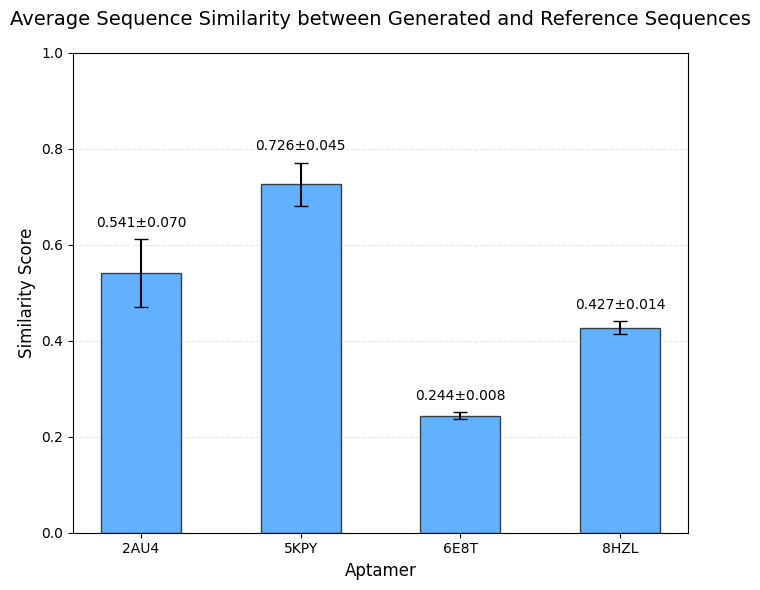

Plot saved as 'similarity_analysis.png'


In [11]:
fig, ax = plt.subplots(figsize=(7, 6))

x_pos = np.arange(len(aptamers))
means = stats['mean'].values
stds = stats['std'].values

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
              color='dodgerblue', edgecolor='black', linewidth=1, width=0.5)

ax.set_xlabel('Aptamer', fontsize=12)
ax.set_ylabel('Similarity Score', fontsize=12,)
ax.set_title('Average Sequence Similarity between Generated and Reference Sequences', 
             fontsize=14, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(aptamers)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{mean:.3f}±{std:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/similarity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'similarity_analysis.png'")

In [12]:
print("\n" + "="*80)
print("SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES")
print("="*80 + "\n")

self_similarity_results = []

for aptamer in aptamers:
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate pairwise similarity between all generated sequences
    similarities = []
    for i in range(len(gen_seqs)):
        for j in range(i + 1, len(gen_seqs)):  # Only upper triangle, avoid self-comparison
            similarity = calculate_similarity(gen_seqs[i], gen_seqs[j])
            similarities.append(similarity)
            self_similarity_results.append({
                'Aptamer': aptamer,
                'Seq1': i + 1,
                'Seq2': j + 1,
                'Similarity': similarity
            })
    
    print(f"{aptamer}: {len(similarities)} pairwise comparisons")

# Create DataFrame for self-similarity
df_self = pd.DataFrame(self_similarity_results)

print("\nSelf-Similarity Statistics:")
self_stats = df_self.groupby('Aptamer')['Similarity'].agg(['mean', 'std', 'count'])
print(self_stats)
print("\n")


SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES

2AU4: 190 pairwise comparisons
5KPY: 190 pairwise comparisons
6E8T: 190 pairwise comparisons
8HZL: 190 pairwise comparisons

Self-Similarity Statistics:
             mean       std  count
Aptamer                           
2AU4     0.619641  0.069073    190
5KPY     0.701408  0.050486    190
6E8T     0.621421  0.042553    190
8HZL     0.721648  0.034378    190




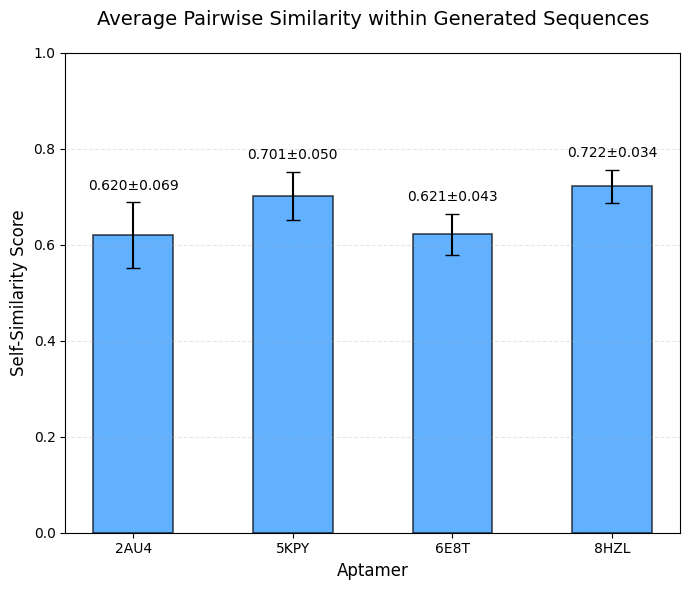

Self-similarity plot saved as 'self_similarity_analysis.png'


In [13]:
# Create bar plot for self-similarity
fig2, ax2 = plt.subplots(figsize=(7, 6))

x_pos = np.arange(len(aptamers))
self_means = self_stats['mean'].values
self_stds = self_stats['std'].values

bars2 = ax2.bar(x_pos, self_means, yerr=self_stds, capsize=5, alpha=0.7, width=0.5,
                color='dodgerblue', edgecolor='black', linewidth=1.2) 

ax2.set_xlabel('Aptamer', fontsize=12)
ax2.set_ylabel('Self-Similarity Score', fontsize=12)
ax2.set_title('Average Pairwise Similarity within Generated Sequences', 
              fontsize=14, pad=20)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(aptamers)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars with padding above error bars
for i, (bar, mean, std) in enumerate(zip(bars2, self_means, self_stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{mean:.3f}±{std:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/self_similarity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Self-similarity plot saved as 'self_similarity_analysis.png'")

## Temp = 5

In [14]:
# dir with generated seqs
aptamers = ["2AU4", "5KPY", "6E8T", "8HZL"]
base_dir = "./generated_seqs_hightemp/"
fasta_dir = "./aptamers/fasta/"

results = []

# Process each aptamer
for aptamer in aptamers:
    # Read reference sequence
    ref_file = os.path.join(fasta_dir, f"{aptamer}.fasta")
    ref_seqs = read_fasta(ref_file)
    ref_seq = ref_seqs[0] if ref_seqs else ""
    
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate similarity for each generated sequence
    for i, gen_seq in enumerate(gen_seqs):
        similarity = calculate_similarity(ref_seq, gen_seq)
        results.append({
            'Aptamer': aptamer,
            'Sequence': i + 1,
            'Similarity': similarity
        })

# Create DataFrame
df = pd.DataFrame(results)

# Pivot to get desired format (rows = sequences, columns = aptamers)
df_pivot = df.pivot(index='Sequence', columns='Aptamer', values='Similarity')

print("Similarity Matrix:")
print(df_pivot)
print("\n")

# Calculate statistics
stats = df.groupby('Aptamer')['Similarity'].agg(['mean', 'std'])
print("Statistics by Aptamer:")
print(stats)
print("\n")


Similarity Matrix:
Aptamer       2AU4      5KPY      6E8T      8HZL
Sequence                                        
1         0.365854  0.492958  0.237762  0.351190
2         0.341463  0.394366  0.237762  0.375000
3         0.365854  0.408451  0.244755  0.392857
4         0.390244  0.394366  0.244755  0.386905
5         0.341463  0.436620  0.251748  0.357143
6         0.365854  0.323944  0.244755  0.386905
7         0.390244  0.436620  0.237762  0.363095
8         0.341463  0.422535  0.237762  0.375000
9         0.317073  0.394366  0.237762  0.363095
10        0.292683  0.450704  0.251748  0.392857
11        0.390244  0.436620  0.244755  0.398810
12        0.414634  0.450704  0.237762  0.363095
13        0.365854  0.464789  0.244755  0.357143
14        0.317073  0.394366  0.230769  0.345238
15        0.463415  0.422535  0.244755  0.369048
16        0.317073  0.408451  0.237762  0.410714
17        0.390244  0.422535  0.251748  0.363095
18        0.365854  0.422535  0.230769  0.369048
1

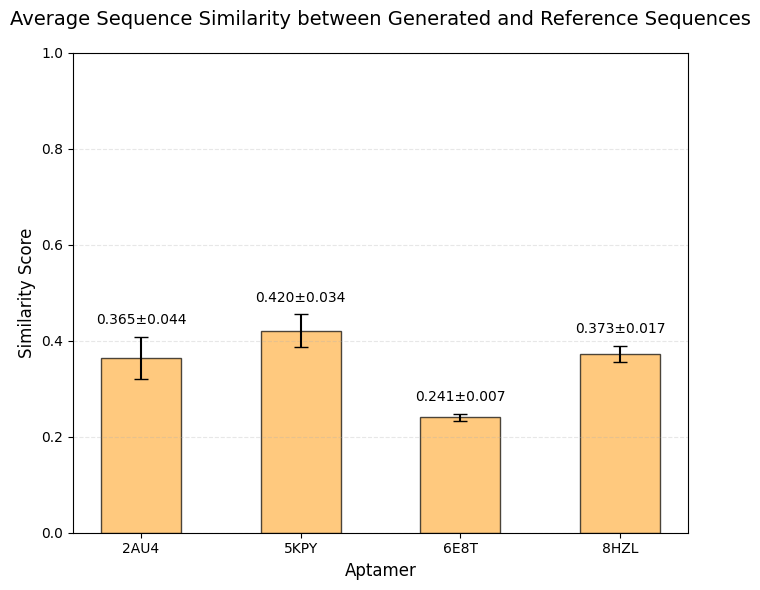

Plot saved as 'similarity_analysis_hightemp.png'


In [15]:
fig, ax = plt.subplots(figsize=(7, 6))

x_pos = np.arange(len(aptamers))
means = stats['mean'].values
stds = stats['std'].values

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
              color='#FFB347', edgecolor='black', linewidth=1, width=0.5)

ax.set_xlabel('Aptamer', fontsize=12)
ax.set_ylabel('Similarity Score', fontsize=12,)
ax.set_title('Average Sequence Similarity between Generated and Reference Sequences', 
             fontsize=14, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(aptamers)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{mean:.3f}±{std:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/similarity_analysis_hightemp.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'similarity_analysis_hightemp.png'")

In [16]:
print("\n" + "="*80)
print("SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES")
print("="*80 + "\n")

self_similarity_results = []

for aptamer in aptamers:
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate pairwise similarity between all generated sequences
    similarities = []
    for i in range(len(gen_seqs)):
        for j in range(i + 1, len(gen_seqs)):  # Only upper triangle, avoid self-comparison
            similarity = calculate_similarity(gen_seqs[i], gen_seqs[j])
            similarities.append(similarity)
            self_similarity_results.append({
                'Aptamer': aptamer,
                'Seq1': i + 1,
                'Seq2': j + 1,
                'Similarity': similarity
            })
    
    print(f"{aptamer}: {len(similarities)} pairwise comparisons")

# Create DataFrame for self-similarity
df_self = pd.DataFrame(self_similarity_results)

print("\nSelf-Similarity Statistics:")
self_stats = df_self.groupby('Aptamer')['Similarity'].agg(['mean', 'std', 'count'])
print(self_stats)
print("\n")


SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES

2AU4: 190 pairwise comparisons
5KPY: 190 pairwise comparisons
6E8T: 190 pairwise comparisons
8HZL: 190 pairwise comparisons

Self-Similarity Statistics:
             mean       std  count
Aptamer                           
2AU4     0.383312  0.053066    190
5KPY     0.387102  0.037016    190
6E8T     0.402576  0.022967    190
8HZL     0.409430  0.021658    190




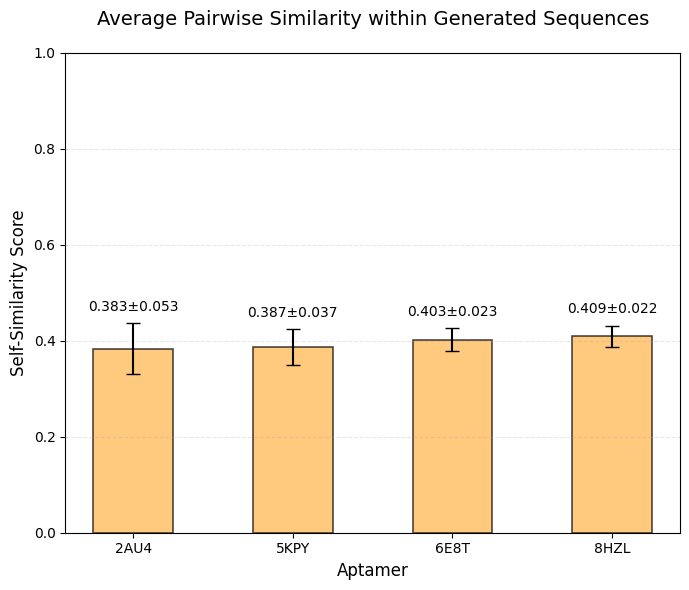

Self-similarity plot saved as 'self_similarity_analysis_hightemp.png'


In [17]:
# Create bar plot for self-similarity
fig2, ax2 = plt.subplots(figsize=(7, 6))

x_pos = np.arange(len(aptamers))
self_means = self_stats['mean'].values
self_stds = self_stats['std'].values

bars2 = ax2.bar(x_pos, self_means, yerr=self_stds, capsize=5, alpha=0.7, width=0.5,
                color='#FFB347', edgecolor='black', linewidth=1.2) 

ax2.set_xlabel('Aptamer', fontsize=12)
ax2.set_ylabel('Self-Similarity Score', fontsize=12)
ax2.set_title('Average Pairwise Similarity within Generated Sequences', 
              fontsize=14, pad=20)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(aptamers)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars with padding above error bars
for i, (bar, mean, std) in enumerate(zip(bars2, self_means, self_stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{mean:.3f}±{std:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/self_similarity_analysis_hightemp.png', dpi=300, bbox_inches='tight')
plt.show()

print("Self-similarity plot saved as 'self_similarity_analysis_hightemp.png'")

## Temp = 1e-5

In [18]:
# dir with generated seqs
aptamers = ["2AU4", "5KPY", "6E8T", "8HZL"]
base_dir = "./generated_seqs_lowtemp/"
fasta_dir = "./aptamers/fasta/"

results = []

# Process each aptamer
for aptamer in aptamers:
    # Read reference sequence
    ref_file = os.path.join(fasta_dir, f"{aptamer}.fasta")
    ref_seqs = read_fasta(ref_file)
    ref_seq = ref_seqs[0] if ref_seqs else ""
    
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate similarity for each generated sequence
    for i, gen_seq in enumerate(gen_seqs):
        similarity = calculate_similarity(ref_seq, gen_seq)
        results.append({
            'Aptamer': aptamer,
            'Sequence': i + 1,
            'Similarity': similarity
        })

# Create DataFrame
df = pd.DataFrame(results)

# Pivot to get desired format (rows = sequences, columns = aptamers)
df_pivot = df.pivot(index='Sequence', columns='Aptamer', values='Similarity')

print("Similarity Matrix:")
print(df_pivot)
print("\n")

# Calculate statistics
stats = df.groupby('Aptamer')['Similarity'].agg(['mean', 'std'])
print("Statistics by Aptamer:")
print(stats)
print("\n")

Similarity Matrix:
Aptamer       2AU4      5KPY      6E8T      8HZL
Sequence                                        
1         0.463415  0.760563  0.251748  0.410714
2         0.463415  0.760563  0.251748  0.410714
3         0.463415  0.760563  0.251748  0.410714
4         0.463415  0.760563  0.251748  0.410714
5         0.463415  0.760563  0.251748  0.410714
6         0.463415  0.760563  0.251748  0.410714
7         0.463415  0.760563  0.251748  0.410714
8         0.463415  0.760563  0.251748  0.410714
9         0.463415  0.760563  0.251748  0.410714
10        0.463415  0.760563  0.251748  0.410714
11        0.463415  0.760563  0.251748  0.410714
12        0.463415  0.760563  0.251748  0.410714
13        0.463415  0.760563  0.251748  0.410714
14        0.463415  0.760563  0.251748  0.410714
15        0.463415  0.760563  0.251748  0.410714
16        0.463415  0.760563  0.251748  0.410714
17        0.463415  0.760563  0.251748  0.410714
18        0.463415  0.760563  0.251748  0.410714
1

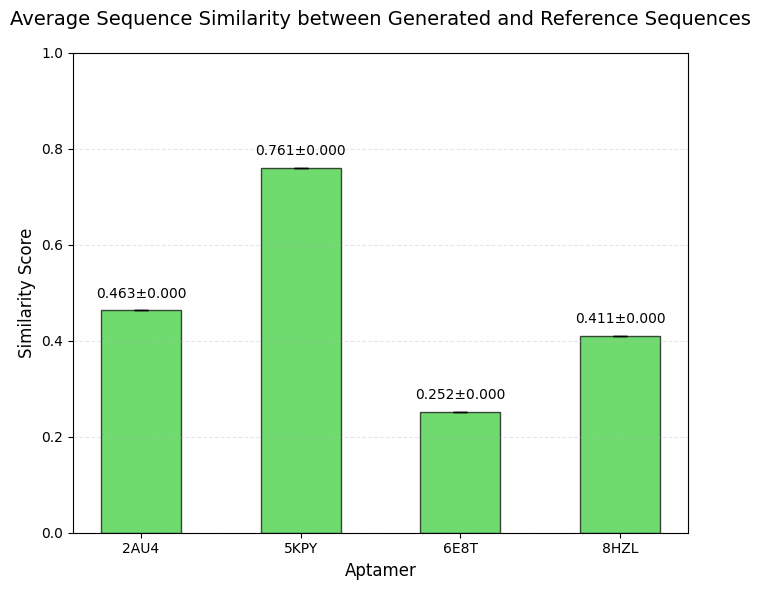

Plot saved as 'similarity_analysis_lowtemp.png'


In [20]:
fig, ax = plt.subplots(figsize=(7, 6))

x_pos = np.arange(len(aptamers))
means = stats['mean'].values
stds = stats['std'].values

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
              color='limegreen', edgecolor='black', linewidth=1, width=0.5)

ax.set_xlabel('Aptamer', fontsize=12)
ax.set_ylabel('Similarity Score', fontsize=12,)
ax.set_title('Average Sequence Similarity between Generated and Reference Sequences', 
             fontsize=14, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(aptamers)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{mean:.3f}±{std:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/similarity_analysis_lowtemp.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'similarity_analysis_lowtemp.png'")

In [21]:
print("\n" + "="*80)
print("SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES")
print("="*80 + "\n")

self_similarity_results = []

for aptamer in aptamers:
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate pairwise similarity between all generated sequences
    similarities = []
    for i in range(len(gen_seqs)):
        for j in range(i + 1, len(gen_seqs)):  # Only upper triangle, avoid self-comparison
            similarity = calculate_similarity(gen_seqs[i], gen_seqs[j])
            similarities.append(similarity)
            self_similarity_results.append({
                'Aptamer': aptamer,
                'Seq1': i + 1,
                'Seq2': j + 1,
                'Similarity': similarity
            })
    
    print(f"{aptamer}: {len(similarities)} pairwise comparisons")

# Create DataFrame for self-similarity
df_self = pd.DataFrame(self_similarity_results)

print("\nSelf-Similarity Statistics:")
self_stats = df_self.groupby('Aptamer')['Similarity'].agg(['mean', 'std', 'count'])
print(self_stats)
print("\n")


SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES

2AU4: 190 pairwise comparisons
5KPY: 190 pairwise comparisons
6E8T: 190 pairwise comparisons
8HZL: 190 pairwise comparisons

Self-Similarity Statistics:
         mean  std  count
Aptamer                  
2AU4      1.0  0.0    190
5KPY      1.0  0.0    190
6E8T      1.0  0.0    190
8HZL      1.0  0.0    190




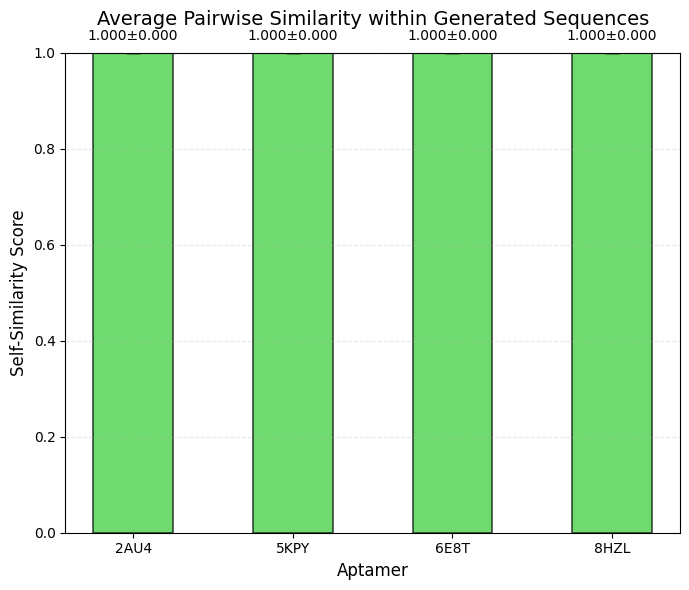

Self-similarity plot saved as 'self_similarity_analysis_lowtemp.png'


In [22]:
# Create bar plot for self-similarity
fig2, ax2 = plt.subplots(figsize=(7, 6))

x_pos = np.arange(len(aptamers))
self_means = self_stats['mean'].values
self_stds = self_stats['std'].values

bars2 = ax2.bar(x_pos, self_means, yerr=self_stds, capsize=5, alpha=0.7, width=0.5,
                color='limegreen', edgecolor='black', linewidth=1.2) 

ax2.set_xlabel('Aptamer', fontsize=12)
ax2.set_ylabel('Self-Similarity Score', fontsize=12)
ax2.set_title('Average Pairwise Similarity within Generated Sequences', 
              fontsize=14, pad=20)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(aptamers)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars with padding above error bars
for i, (bar, mean, std) in enumerate(zip(bars2, self_means, self_stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{mean:.3f}±{std:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/self_similarity_analysis_lowtemp.png', dpi=300, bbox_inches='tight')
plt.show()

print("Self-similarity plot saved as 'self_similarity_analysis_lowtemp.png'")